### Introduction
For the project, I have analysed historical data from 494 companies, describing 28 properties of each company such as profits, debts, assets, sales. The data also includes whether or not the company went bankrupt in the next year. I have used this data to get a picture of the properties of a company at risk of bankruptcy and to predict whether a company will go bankrupt. I use two models, a Bayesian logistic regression, and a Gaussian mixture model. 

In [12]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [40]:
data = np.loadtxt('data2.csv', delimiter = ',', skiprows = 4, usecols = range(1,30))
data_scaled = normalize(data, axis = 0)
X = data_scaled[:,1:]
Y = data_scaled[:,0]
print(data.shape)
print(X.shape)
print(Y.shape)

(494, 29)
(494, 28)
(494,)


(array([  1., 463.,  26.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.12465843, -0.03747844,  0.04970155,  0.13688155,  0.22406154,
         0.31124153,  0.39842153,  0.48560152,  0.57278151,  0.65996151,
         0.7471415 ]),
 <BarContainer object of 10 artists>)

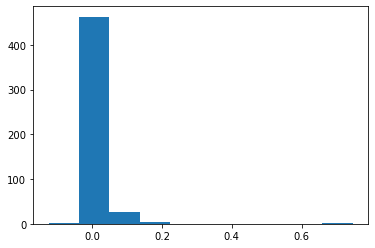

In [53]:
plt.hist(X[:,4])

### Bayesian Logistic Regression

For this model, I assume that the outcome $y$ depends on the $x$ and hidden coefficients $\beta$
![regm](figs/regm.png)
I consider two generative models, with different priors.

Model 1
$$\beta_j \sim N(0,1/\lambda) $$
$$y_i \vert x_i \sim \textrm{Bern}\left(\sigma\left(\beta^Tx_i\right)\right)$$


Model 2
$$\beta \sim \textrm{Laplace}(\boldsymbol{0},1/\lambda I) $$
$$y_i \vert x_i \sim \textrm{Bern}\left(\sigma\left(\beta^Tx_i\right)\right)$$



#### Infer hidden quantities
We want to maximize the log-posterior probability. We will do so with a gradient ascent algorithm on the hidden ascent algorithm on $\beta$

\begin{align*}
\mathcal L &= \log p(\beta, y\vert x) \\
           &= \sum_{i=1}^n (y_i\log\sigma(\beta^Tx_i) + (1-y_i)\log\sigma(-\beta^Tx_i)) - \sum_{j=1}^p\lambda\beta_j^2
\end{align*}


Model 1
$$\nabla_\beta\mathcal L = \sum_{i=1}^n(y_i - \sigma(\beta^Tx_i))x_i - \lambda\beta$$

Model 2
$$\nabla_\beta \mathcal L = \sum_{i=1}^n(y_i -\sigma(\beta^Tx_i))x_i - \lambda\textrm{sign}\beta$$


The priors in models 1 and 2 correspond to ridge and lasso regularizations respectively.

Since our data set is not too large, in each case, we can do batch gradient ascent, as opposed to stochastic gradient ascent, i.e.

$$\beta \leftarrow \beta + \eta\nabla_\beta\mathcal L$$

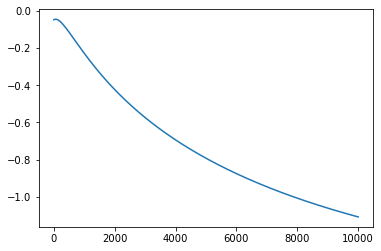

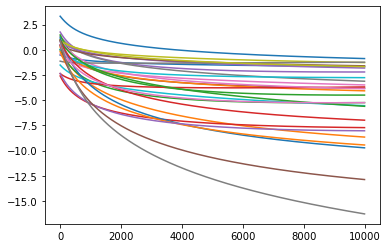

In [54]:
iterations = 10000
lam = 0.001
d = X.shape[1]
n = X.shape[0]

eta = 0.001

sigmoid = lambda x : 1/(1+np.exp(-x))


beta = np.random.normal(loc = 0, scale = 1.0, size = d)
#beta = np.zeros(d)
beta_list = []
log_posterior_list = []
beta0list = []
for r in range(iterations):
    #print(beta)
    beta_list.append(beta.copy())
    
    log_posterior = -lam*np.sum(beta**2)
    nablaL = -lam*beta
    for i in range(n):
        beta_x = np.dot(beta,X[i,:])
        #log_posterior += Y[i]*np.log(sigmoid(beta_x)) + (1-Y[i])*np.log(sigmoid(-beta_x))
        nablaL += (Y[i]-sigmoid(beta_x))*X[i]
        
    log_posterior_list.append(log_posterior)
    beta += eta*nablaL
    beta0list.append(beta[0])
    #print(beta[0])

beta_array = np.array(beta_list)
    
plt.plot(range(len(log_posterior_list)),log_posterior_list)
plt.figure()
plt.plot(range(len(log_posterior_list)),beta_list)
plt.show()



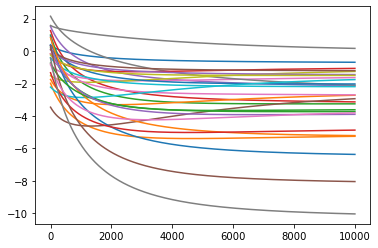

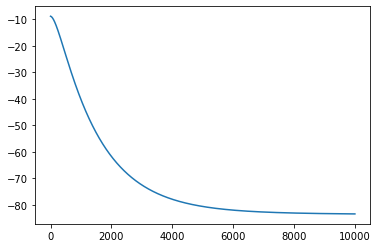

In [47]:
plt.plot(range(len(log_posterior_list)),beta_list)
plt.show()
plt.plot(range(len(log_posterior_list)),log_posterior_list)
plt.show()

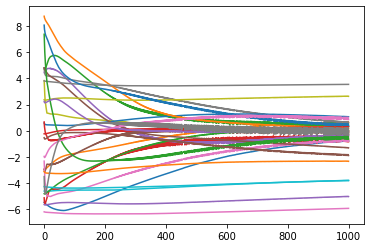

In [159]:
iterations = 1000
lam = 0.2
d = X.shape[1]
n = X.shape[0]

eta = 0.001

sigmoid = lambda x : 1/(1+np.exp(-x))


beta = np.random.normal(loc = 0, scale = 1/lam, size = d)
#beta = np.zeros(d)
beta_list = []
log_posterior_list = []
beta0list = []
for r in range(iterations):
    #print(beta)
    beta_list.append(beta.copy())
    
    log_posterior = -lam*np.sum(beta**2)
    nablaL = -lam*np.sign(beta)
    for i in range(n):
        beta_x = np.dot(beta,X[i,:])
        #log_posterior += Y[i]*np.log(sigmoid(beta_x)) + (1-Y[i])*np.log(sigmoid(-beta_x))
        nablaL += (Y[i]-sigmoid(beta_x))*X[i]
        
    log_posterior_list.append(log_posterior)
    beta += eta*nablaL
    beta0list.append(beta[0])
    #print(beta[0])

beta_array = np.array(beta_list)
    
#plt.plot(range(len(log_posterior_list)),log_posterior_list)
plt.plot(range(len(log_posterior_list)),beta_list)


## test train split

In [55]:
data = normalize(np.loadtxt('data2.csv', delimiter = ',', skiprows = 4, usecols = range(1,30)), axis = 0)
np.random.shuffle(data)
train_data = data[:int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]
X = train_data[:,1:]
Y = train_data[:,0]
X_test = test_data[:,1:]
Y_test = test_data[:,0]


In [57]:

iterations = 10000
lam = 0.0001
d = X.shape[1]
n = X.shape[0]

eta = 0.001

sigmoid = lambda x : 1/(1+np.exp(-x))


#beta = np.random.normal(loc = 0, scale = 1/lam, size = d)
beta = np.zeros(d)
beta_list = []
log_posterior_list = []
beta0list = []
trainMSE_list = []
testMSE_list = []
for r in range(iterations):
    #print(beta)
    beta_list.append(beta.copy())
    
    testMSE = sum((Y_test - sigmoid(np.dot(beta,X_test.transpose())))**2)/len(Y_test)
    testMSE_list.append(testMSE)
    trainMSE = sum(abs(Y - sigmoid(np.dot(beta,X.transpose()))))/len(Y)
    trainMSE_list.append(trainMSE)
    
    log_posterior = -lam*np.sum(beta**2)
    nablaL = -lam*beta
    for i in range(n):
        beta_x = np.dot(beta,X[i,:])
        #log_posterior += Y[i]*np.log(sigmoid(beta_x)) + (1-Y[i])*np.log(sigmoid(-beta_x))
        nablaL += (Y[i]-sigmoid(beta_x))*X[i]
        
    log_posterior_list.append(log_posterior)
    beta += eta*nablaL
    beta0list.append(beta[0])
    #print(beta[0])

beta_array = np.array(beta_list)
    
#plt.plot(range(len(log_posterior_list)),log_posterior_list)

print(1)


1


Text(0.5, 1.0, 'Coefficients model 1 (ridge)')

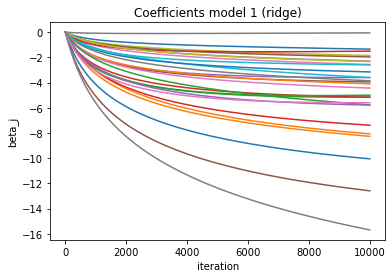

In [58]:
plt.plot(range(len(log_posterior_list)),beta_list)
plt.xlabel('iteration')
plt.ylabel('beta_j')
plt.title('Coefficients model 1 (ridge)')

Text(0.5, 1.0, 'Train error model 1 (ridge)')

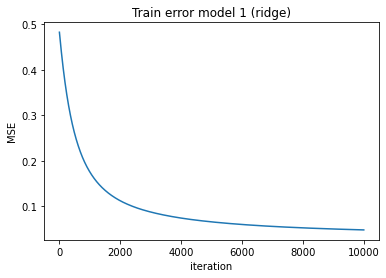

In [59]:
plt.plot(range(iterations),trainMSE_list)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.title('Train error model 1 (ridge)')

Text(0.5, 1.0, 'Train error model 2 (lasso)')

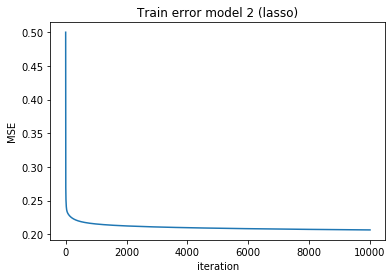

In [344]:
plt.plot(range(iterations),trainMSE_list)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.title('Train error model 2 (lasso)')

Text(0.5, 1.0, 'Test error model 2 (lasso)')

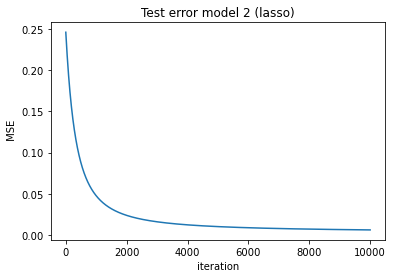

In [60]:
plt.plot(range(iterations),testMSE_list)
plt.xlabel('iteration')
plt.ylabel(' MSE')
plt.title('Test error model 2 (lasso)')

#### l1

1


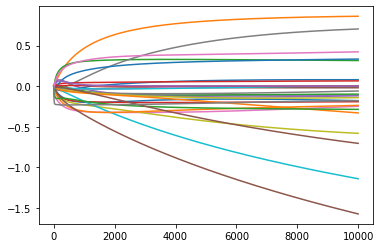

In [334]:

iterations = 10000
lam = 0.2
d = X.shape[1]
n = X_train.shape[0]

eta = 0.0001

sigmoid = lambda x : 1/(1+np.exp(-x))


#beta = np.random.normal(loc = 0, scale = 1/lam, size = d)
beta = np.zeros(d)
beta_list = []
log_posterior_list = []
beta0list = []
trainMSE_list = []
testMSE_list = []
for r in range(iterations):
    #print(beta)
    beta_list.append(beta.copy())
    
    testMSE = sum((Y_test - sigmoid(np.dot(beta,X_test.transpose())))**2)/len(Y_test)
    testMSE_list.append(testMSE)
    trainMSE = sum(abs(Y - sigmoid(np.dot(beta,X.transpose()))))/len(Y)
    trainMSE_list.append(trainMSE)
    
    log_posterior = -lam*np.sum(abs(beta))
    nablaL = -lam*np.sign(beta)
    for i in range(n):
        beta_x = np.dot(beta,X[i,:])
        #log_posterior += Y[i]*np.log(sigmoid(beta_x)) + (1-Y[i])*np.log(sigmoid(-beta_x))
        nablaL += (Y[i]-sigmoid(beta_x))*X[i]
        
    log_posterior_list.append(log_posterior)
    beta += eta*nablaL
    beta0list.append(beta[0])
    #print(beta[0])

beta_array = np.array(beta_list)
    
#plt.plot(range(len(log_posterior_list)),log_posterior_list)
plt.plot(range(len(log_posterior_list)),beta_list)
print(1)


Text(0.5, 1.0, 'Coefficients model 2 (lasso)')

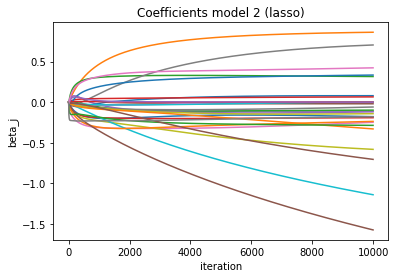

In [343]:
plt.plot(range(len(log_posterior_list)),beta_list)
plt.xlabel('iteration')
plt.ylabel('beta_j')
plt.title('Coefficients model 2 (lasso)')

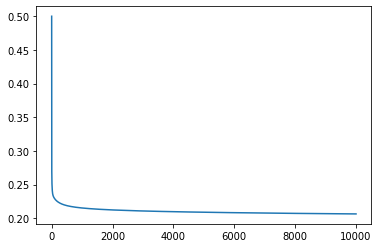

In [191]:
plt.plot(range(iterations),trainMSE_list)

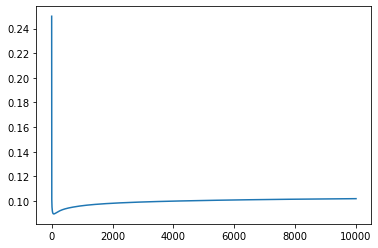

In [192]:
plt.plot(range(iterations),testMSE_list)

In [ ]:
np.random.shuffle(data)
train_data = data[:int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]
X = train_data[:,1:]
Y = train_data[:,0]
X_test = test_data[:,1:]
Y_test = test_data[:,0]


In [167]:
X_test = test_data[:,1:]
Y_test = test_data[:,0]

sum((Y_test - sigmoid(np.dot(beta,X_test.transpose())))**2)/len(Y_test)


0.10892471224887716

In [169]:
sum(abs(Y - sigmoid(np.dot(beta,X.transpose()))))/len(Y)

0.1614293546845753

In [139]:
print(beta_list)

[array([ -0.61763778,  -0.40294624,  -5.2940399 , -16.46461017,
        -3.54328228, -10.23940676,  -6.2489846 ,  -2.51301816,
        -4.66002171,  -0.40823144,  -0.60001141,  -2.20704258,
        -0.7455968 ,  -5.08095089,  -0.55897093,  -1.18774434,
        -0.17205629,  -0.21511259,  -0.55741087,  -0.13239569,
        -4.45669065,  -0.54344751,  -8.33584043,  -0.17308388,
        -1.40905449,  -1.92254863,  -2.88716162, -15.6113695 ]), array([ -0.61763778,  -0.40294624,  -5.2940399 , -16.46461017,
        -3.54328228, -10.23940676,  -6.2489846 ,  -2.51301816,
        -4.66002171,  -0.40823144,  -0.60001141,  -2.20704258,
        -0.7455968 ,  -5.08095089,  -0.55897093,  -1.18774434,
        -0.17205629,  -0.21511259,  -0.55741087,  -0.13239569,
        -4.45669065,  -0.54344751,  -8.33584043,  -0.17308388,
        -1.40905449,  -1.92254863,  -2.88716162, -15.6113695 ]), array([ -0.61763778,  -0.40294624,  -5.2940399 , -16.46461017,
        -3.54328228, -10.23940676,  -6.2489846 ,  

In [99]:
Y - sigmoid(np.dot(beta,X.transpose()))

array([-2.36772484e-039, -1.59434657e-024, -1.64400403e-021,
       -2.71507738e-020, -1.61053426e-051, -7.70449352e-030,
       -1.02573587e-018, -1.06220335e-024, -6.75785383e-020,
       -3.60415662e-021, -1.50982584e-024, -7.95666916e-022,
       -2.06503308e-018, -1.23191914e-021, -3.73364954e-020,
       -2.45921522e-040, -1.65610927e-032, -1.99121500e-120,
       -4.83079211e-019, -2.07480166e-014, -1.19697760e-022,
       -2.90477975e-020, -5.84447082e-034, -6.08314652e-037,
       -1.08192583e-021, -4.95082302e-022, -1.15561973e-016,
       -3.82274251e-028, -1.74673768e-025, -1.57499869e-032,
       -1.10608948e-020, -5.11035842e-020, -3.75057532e-020,
       -4.47716062e-025, -2.56534728e-025, -1.68075908e-016,
       -9.44344907e-022, -6.45716612e-061, -3.98061375e-020,
       -6.59581141e-051, -1.14922896e-038, -1.44121824e-019,
       -3.83946440e-018, -4.43846502e-025, -4.31597525e-013,
       -4.77512010e-030, -1.90091252e-020, -6.33292710e-020,
       -3.58776172e-016,

In [129]:
print(beta)

[ -0.61763778  -0.40294624  -5.2940399  -16.46461017  -3.54328228
 -10.23940676  -6.2489846   -2.51301816  -4.66002171  -0.40823144
  -0.60001141  -2.20704258  -0.7455968   -5.08095089  -0.55897093
  -1.18774434  -0.17205629  -0.21511259  -0.55741087  -0.13239569
  -4.45669065  -0.54344751  -8.33584043  -0.17308388  -1.40905449
  -1.92254863  -2.88716162 -15.6113695 ]


In [132]:
l = []
l.append(np.zeros(d))
l.append(beta)
print(l)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ -0.61763778,  -0.40294624,  -5.2940399 , -16.46461017,
        -3.54328228, -10.23940676,  -6.2489846 ,  -2.51301816,
        -4.66002171,  -0.40823144,  -0.60001141,  -2.20704258,
        -0.7455968 ,  -5.08095089,  -0.55897093,  -1.18774434,
        -0.17205629,  -0.21511259,  -0.55741087,  -0.13239569,
        -4.45669065,  -0.54344751,  -8.33584043,  -0.17308388,
        -1.40905449,  -1.92254863,  -2.88716162, -15.6113695 ])]


In [93]:
print(beta_list[0]-beta_list[999])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [299]:
data = np.loadtxt('data2.csv', delimiter = ',', skiprows = 4, usecols = range(1,30))
x = data[:,1:]


n = x.shape[0]
d = x.shape[1]
c = 2

yes = np.zeros((c,d))
no = np.zeros((c,d))

alpha_0 = 1.0
beta_0 = 1.0
gamma = np.ones(c)

lam = 1
sigma = 10
 

def gibbs():
    mu0 = np.array([np.sum(x, axis = 0)/n,np.sum(x, axis = 0)/n]).transpose()
    mu = np.random.normal(loc = mu0, scale = lam, size = (d,c))
    #mu = np.random.normal(size = (d,c))
    #var = st.invgamma.rvs(1, size = (d,c))  
    phi = sum(data[:,0])/len(data[:,0])
    z = st.bernoulli.rvs(phi, size = n)

    ljs = []
    for r in range(1000):  
            print("***   "+str(r)+"   ***")
            log_joint = -np.sum((mu-mu0)**2/(2*lam**2))

            for i in range(n):
                log_joint += (1-phi)*(1-z[i]) + phi*z[i]

            for i in range(n):
                for j in range(d):
                    log_joint -= (x[i,j] - mu[j,z[i]])**2/(2*sigma)**2 

            ljs.append(log_joint)        


            #sample z_i
            for i in range(n):
                pz0 = np.log(1-phi)
                for j in range(d):
                    #pz0 += st.norm.logpdf(x[i,j], loc = mu[j,0], scale = sigma**2)
                    pz0 -= (x[i,j]-mu[j,0])**2/(2*sigma**2)
                pz0 = np.exp(pz0)
                #print(pz0)
                
                pz1 = np.log(phi)
                for j in range(d):
                    #pz1 += st.norm.logpdf(x[i,j], loc = mu[j,1], scale = sigma**2)
                    pz1 -= (x[i,j]-mu[j,1])**2/(2*sigma**2)
                pz1 = np.exp(pz1)
                #print(pz1)
                
                pzk = np.array([pz0,pz1])/(pz0 + pz1)
                z[i] = np.random.choice(c, p = pzk)

            #sample theta
            bins = np.bincount(z, minlength = 2)
            #phi = np.random.dirichlet(gamma + bins)
        
            xsum = np.zeros((d,c))
            for i in range(n):
                if z[i] == 0:
                    xsum[:,0] += x[i,:]
                else:
                    xsum[:,1] += x[i,:]
            
            #sample mu
            for k in range(c):
                for j in range(d):
                    mu[j,k] = np.random.normal((mu0[j,k]/lam**2 + xsum[j,k]/sigma**2)/(bins[k]/sigma**2 + 1/lam**2), 1/(bins[k]/sigma**2 + 1/lam**2) )
          
    return ljs, mu, z
        



In [294]:
np.sum(mu - mu**2)

-117.60649002682663

In [295]:
ljs, mu, z = gibbs()

***   0   ***
***   1   ***
***   2   ***
***   3   ***
***   4   ***
***   5   ***
***   6   ***
***   7   ***
***   8   ***
***   9   ***
***   10   ***
***   11   ***
***   12   ***
***   13   ***
***   14   ***


KeyboardInterrupt: 

In [ ]:
print(z)

In [302]:
ljs1, mu1, z1 = gibbs()
ljs2, mu2, z2 = gibbs()
ljs3, mu3, z3 = gibbs()


***   0   ***
***   1   ***
***   2   ***
***   3   ***
***   4   ***
***   5   ***
***   6   ***
***   7   ***
***   8   ***
***   9   ***
***   10   ***
***   11   ***
***   12   ***
***   13   ***
***   14   ***
***   15   ***
***   16   ***
***   17   ***
***   18   ***
***   19   ***
***   20   ***
***   21   ***
***   22   ***
***   23   ***
***   24   ***
***   25   ***
***   26   ***
***   27   ***
***   28   ***
***   29   ***
***   30   ***
***   31   ***
***   32   ***
***   33   ***
***   34   ***
***   35   ***
***   36   ***
***   37   ***
***   38   ***
***   39   ***
***   40   ***
***   41   ***
***   42   ***
***   43   ***
***   44   ***
***   45   ***
***   46   ***
***   47   ***
***   48   ***
***   49   ***
***   50   ***
***   51   ***
***   52   ***
***   53   ***
***   54   ***
***   55   ***
***   56   ***
***   57   ***
***   58   ***
***   59   ***
***   60   ***
***   61   ***
***   62   ***
***   63   ***
***   64   ***
***   65   ***
***   66   ***
***  

***   519   ***
***   520   ***
***   521   ***
***   522   ***
***   523   ***
***   524   ***
***   525   ***
***   526   ***
***   527   ***
***   528   ***
***   529   ***
***   530   ***
***   531   ***
***   532   ***
***   533   ***
***   534   ***
***   535   ***
***   536   ***
***   537   ***
***   538   ***
***   539   ***
***   540   ***
***   541   ***
***   542   ***
***   543   ***
***   544   ***
***   545   ***
***   546   ***
***   547   ***
***   548   ***
***   549   ***
***   550   ***
***   551   ***
***   552   ***
***   553   ***
***   554   ***
***   555   ***
***   556   ***
***   557   ***
***   558   ***
***   559   ***
***   560   ***
***   561   ***
***   562   ***
***   563   ***
***   564   ***
***   565   ***
***   566   ***
***   567   ***
***   568   ***
***   569   ***
***   570   ***
***   571   ***
***   572   ***
***   573   ***
***   574   ***
***   575   ***
***   576   ***
***   577   ***
***   578   ***
***   579   ***
***   580   ***
***   58

***   35   ***
***   36   ***
***   37   ***
***   38   ***
***   39   ***
***   40   ***
***   41   ***
***   42   ***
***   43   ***
***   44   ***
***   45   ***
***   46   ***
***   47   ***
***   48   ***
***   49   ***
***   50   ***
***   51   ***
***   52   ***
***   53   ***
***   54   ***
***   55   ***
***   56   ***
***   57   ***
***   58   ***
***   59   ***
***   60   ***
***   61   ***
***   62   ***
***   63   ***
***   64   ***
***   65   ***
***   66   ***
***   67   ***
***   68   ***
***   69   ***
***   70   ***
***   71   ***
***   72   ***
***   73   ***
***   74   ***
***   75   ***
***   76   ***
***   77   ***
***   78   ***
***   79   ***
***   80   ***
***   81   ***
***   82   ***
***   83   ***
***   84   ***
***   85   ***
***   86   ***
***   87   ***
***   88   ***
***   89   ***
***   90   ***
***   91   ***
***   92   ***
***   93   ***
***   94   ***
***   95   ***
***   96   ***
***   97   ***
***   98   ***
***   99   ***
***   100   ***
***   101

***   552   ***
***   553   ***
***   554   ***
***   555   ***
***   556   ***
***   557   ***
***   558   ***
***   559   ***
***   560   ***
***   561   ***
***   562   ***
***   563   ***
***   564   ***
***   565   ***
***   566   ***
***   567   ***
***   568   ***
***   569   ***
***   570   ***
***   571   ***
***   572   ***
***   573   ***
***   574   ***
***   575   ***
***   576   ***
***   577   ***
***   578   ***
***   579   ***
***   580   ***
***   581   ***
***   582   ***
***   583   ***
***   584   ***
***   585   ***
***   586   ***
***   587   ***
***   588   ***
***   589   ***
***   590   ***
***   591   ***
***   592   ***
***   593   ***
***   594   ***
***   595   ***
***   596   ***
***   597   ***
***   598   ***
***   599   ***
***   600   ***
***   601   ***
***   602   ***
***   603   ***
***   604   ***
***   605   ***
***   606   ***
***   607   ***
***   608   ***
***   609   ***
***   610   ***
***   611   ***
***   612   ***
***   613   ***
***   61

***   69   ***
***   70   ***
***   71   ***
***   72   ***
***   73   ***
***   74   ***
***   75   ***
***   76   ***
***   77   ***
***   78   ***
***   79   ***
***   80   ***
***   81   ***
***   82   ***
***   83   ***
***   84   ***
***   85   ***
***   86   ***
***   87   ***
***   88   ***
***   89   ***
***   90   ***
***   91   ***
***   92   ***
***   93   ***
***   94   ***
***   95   ***
***   96   ***
***   97   ***
***   98   ***
***   99   ***
***   100   ***
***   101   ***
***   102   ***
***   103   ***
***   104   ***
***   105   ***
***   106   ***
***   107   ***
***   108   ***
***   109   ***
***   110   ***
***   111   ***
***   112   ***
***   113   ***
***   114   ***
***   115   ***
***   116   ***
***   117   ***
***   118   ***
***   119   ***
***   120   ***
***   121   ***
***   122   ***
***   123   ***
***   124   ***
***   125   ***
***   126   ***
***   127   ***
***   128   ***
***   129   ***
***   130   ***
***   131   ***
***   132   ***
***   1

***   583   ***
***   584   ***
***   585   ***
***   586   ***
***   587   ***
***   588   ***
***   589   ***
***   590   ***
***   591   ***
***   592   ***
***   593   ***
***   594   ***
***   595   ***
***   596   ***
***   597   ***
***   598   ***
***   599   ***
***   600   ***
***   601   ***
***   602   ***
***   603   ***
***   604   ***
***   605   ***
***   606   ***
***   607   ***
***   608   ***
***   609   ***
***   610   ***
***   611   ***
***   612   ***
***   613   ***
***   614   ***
***   615   ***
***   616   ***
***   617   ***
***   618   ***
***   619   ***
***   620   ***
***   621   ***
***   622   ***
***   623   ***
***   624   ***
***   625   ***
***   626   ***
***   627   ***
***   628   ***
***   629   ***
***   630   ***
***   631   ***
***   632   ***
***   633   ***
***   634   ***
***   635   ***
***   636   ***
***   637   ***
***   638   ***
***   639   ***
***   640   ***
***   641   ***
***   642   ***
***   643   ***
***   644   ***
***   64

Text(0, 0.5, 'log joint')

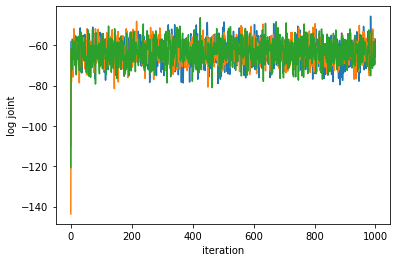

In [335]:
plt.plot(range(len(ljs1)),ljs1)
plt.plot(range(len(ljs2)),ljs2)
plt.plot(range(len(ljs3)),ljs3)
plt.xlabel('iteration')
plt.ylabel('log joint')

***   0   ***
***   1   ***
***   2   ***
***   3   ***
***   4   ***
***   5   ***
***   6   ***
***   7   ***
***   8   ***
***   9   ***
***   10   ***
***   11   ***
***   12   ***
***   13   ***
***   14   ***
***   15   ***
***   16   ***
***   17   ***
***   18   ***
***   19   ***
***   20   ***
***   21   ***
***   22   ***
***   23   ***
***   24   ***
***   25   ***
***   26   ***
***   27   ***
***   28   ***
***   29   ***
***   30   ***
***   31   ***
***   32   ***
***   33   ***
***   34   ***
***   35   ***
***   36   ***
***   37   ***
***   38   ***
***   39   ***
***   40   ***
***   41   ***
***   42   ***
***   43   ***
***   44   ***
***   45   ***
***   46   ***
***   47   ***
***   48   ***
***   49   ***
***   50   ***
***   51   ***
***   52   ***
***   53   ***
***   54   ***
***   55   ***
***   56   ***
***   57   ***
***   58   ***
***   59   ***
***   60   ***
***   61   ***
***   62   ***
***   63   ***
***   64   ***
***   65   ***
***   66   ***
***  

***   520   ***
***   521   ***
***   522   ***
***   523   ***
***   524   ***
***   525   ***
***   526   ***
***   527   ***
***   528   ***
***   529   ***
***   530   ***
***   531   ***
***   532   ***
***   533   ***
***   534   ***
***   535   ***
***   536   ***
***   537   ***
***   538   ***
***   539   ***
***   540   ***
***   541   ***
***   542   ***
***   543   ***
***   544   ***
***   545   ***
***   546   ***
***   547   ***
***   548   ***
***   549   ***
***   550   ***
***   551   ***
***   552   ***
***   553   ***
***   554   ***
***   555   ***
***   556   ***
***   557   ***
***   558   ***
***   559   ***
***   560   ***
***   561   ***
***   562   ***
***   563   ***
***   564   ***
***   565   ***
***   566   ***
***   567   ***
***   568   ***
***   569   ***
***   570   ***
***   571   ***
***   572   ***
***   573   ***
***   574   ***
***   575   ***
***   576   ***
***   577   ***
***   578   ***
***   579   ***
***   580   ***
***   581   ***
***   58

***   36   ***
***   37   ***
***   38   ***
***   39   ***
***   40   ***
***   41   ***
***   42   ***
***   43   ***
***   44   ***
***   45   ***
***   46   ***
***   47   ***
***   48   ***
***   49   ***
***   50   ***
***   51   ***
***   52   ***
***   53   ***
***   54   ***
***   55   ***
***   56   ***
***   57   ***
***   58   ***
***   59   ***
***   60   ***
***   61   ***
***   62   ***
***   63   ***
***   64   ***
***   65   ***
***   66   ***
***   67   ***
***   68   ***
***   69   ***
***   70   ***
***   71   ***
***   72   ***
***   73   ***
***   74   ***
***   75   ***
***   76   ***
***   77   ***
***   78   ***
***   79   ***
***   80   ***
***   81   ***
***   82   ***
***   83   ***
***   84   ***
***   85   ***
***   86   ***
***   87   ***
***   88   ***
***   89   ***
***   90   ***
***   91   ***
***   92   ***
***   93   ***
***   94   ***
***   95   ***
***   96   ***
***   97   ***
***   98   ***
***   99   ***
***   100   ***
***   101   ***
***   10

***   553   ***
***   554   ***
***   555   ***
***   556   ***
***   557   ***
***   558   ***
***   559   ***
***   560   ***
***   561   ***
***   562   ***
***   563   ***
***   564   ***
***   565   ***
***   566   ***
***   567   ***
***   568   ***
***   569   ***
***   570   ***
***   571   ***
***   572   ***
***   573   ***
***   574   ***
***   575   ***
***   576   ***
***   577   ***
***   578   ***
***   579   ***
***   580   ***
***   581   ***
***   582   ***
***   583   ***
***   584   ***
***   585   ***
***   586   ***
***   587   ***
***   588   ***
***   589   ***
***   590   ***
***   591   ***
***   592   ***
***   593   ***
***   594   ***
***   595   ***
***   596   ***
***   597   ***
***   598   ***
***   599   ***
***   600   ***
***   601   ***
***   602   ***
***   603   ***
***   604   ***
***   605   ***
***   606   ***
***   607   ***
***   608   ***
***   609   ***
***   610   ***
***   611   ***
***   612   ***
***   613   ***
***   614   ***
***   61

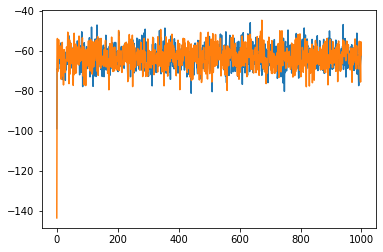

In [300]:
for run in range(2):
    ljs, mu, z = gibbs()
    plt.plot(range(len(ljs)),ljs)

In [321]:
1-sum(abs(z-data[:,0]))/len(z)

0.7813765182186234

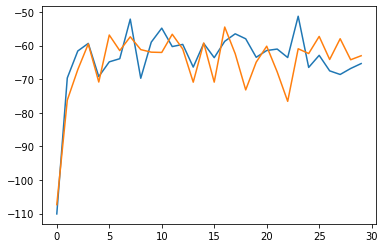

In [292]:
plt.plot(range(len(ljs)),ljs)
plt.plot(range(len(ljs2)),ljs2)

In [211]:
print(data[:,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [199]:
len(np.sum(x, axis = 0))

28

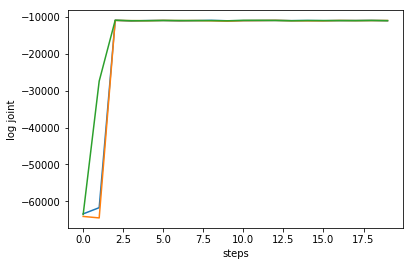

In [138]:
for rerun in range(3):
    ljs, theta, beta, z = gibbs()
    plt.plot(range(len(ljs)),ljs)
    
plt.xlabel('steps')
plt.ylabel('log joint')
plt.show()


In [141]:
1-scipy.spatial.distance.hamming(z, party)

0.96116504854368934

array([[ 0.3999024 ,  0.33117127,  0.83403263,  1.39722372],
       [ 1.57790281,  0.90673373,  6.03117886,  3.58997639],
       [ 1.38249036,  0.39864787,  1.74200558, 10.58729722]])

In [193]:
x = data[:,1:]
z = data[:,0]


In [197]:
sum(z)/len(z)

0.13360323886639677